In [4]:
# Standard library imports
import os
from collections import Counter
import copy
import shutil
import csv
import re

# Data handling and numerical processing
import numpy as np
import pandas as pd


# Image processing
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt

import cv2
import numpy as np
import matplotlib.pyplot as plt

import json
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tifffile import tifffile 

In [12]:
def plot_9_channels_with_bboxes(image, bboxes, title_prefix):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import patches

    if len(image.shape) == 2:  # Single-channel image (grayscale)
        B, G, R = image, image, image
        image_hsv = np.stack((image, image, image), axis=-1)  # Create dummy HSV image
        H, S, V = image, image, image
        image_rgb = np.stack((image, image, image), axis=-1)  # Create dummy RGB image
    elif len(image.shape) == 3 and image.shape[2] == 3:  # Multi-channel image (e.g., RGB)
        B, G, R = cv2.split(image)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        H, S, V = cv2.split(image_hsv)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("Unsupported image format")

    # Define the transformation matrix from RGB to YIQ
    transform_matrix = np.array([[0.299, 0.587, 0.114],
                                [0.596, -0.274, -0.322],
                                [0.211, -0.523, 0.312]])

    # Apply the transformation matrix
    yiq = np.dot(image_rgb, transform_matrix.T) if len(image.shape) == 3 else np.zeros_like(image_rgb)
    if len(image.shape) == 3:
        yiq[:, :, 1:] = (yiq[:, :, 1:] + 0.5957) / 1.1914  # Normalize I and Q between 0 and 1

    # Prepare figures and axes
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    titles = [f'{title_prefix} - Red Channel', f'{title_prefix} - Green Channel', f'{title_prefix} - Blue Channel',
            f'{title_prefix} - Hue Channel', f'{title_prefix} - Saturation Channel', f'{title_prefix} - Value Channel',
            f'{title_prefix} - Y Channel', f'{title_prefix} - I Channel', f'{title_prefix} - Q Channel']
    channels = [R, G, B, H, S, V, yiq[:, :, 0] if len(image.shape) == 3 else image, 
                yiq[:, :, 1] if len(image.shape) == 3 else image, 
                yiq[:, :, 2] if len(image.shape) == 3 else image]
    cmaps = ['Reds', 'Greens', 'Blues', 'hsv', 'coolwarm', 'gray', 'gray', 'coolwarm', 'coolwarm']

    # Plot each channel
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(channels[i], cmap=cmaps[i])
        ax.set_title(titles[i])
        ax.axis('off')

        # Draw bounding boxes
        for box in bboxes:
            x, y = box['pixel_within_patch_coordinates']
            rect = patches.Circle((x, y), radius=20, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)  # Adjusted colorbar size

    plt.tight_layout()
    plt.show()

def plot_images_and_9_channels(sample_info):
    src_SI = 'swissImage_50cm_patches/' + sample_info['file_name']
    src_SS = 'swissSURFACE3D_patches/' + sample_info['file_name']
    src_HS = 'swissSURFACE3D_hillshade_patches/' + sample_info['file_name']

    # Read and draw the bounding boxes
    bboxes = sample_info['rocks_annotations']

    # Open and process the images
    image_SI = tifffile.imread(src_SI)
    image_SS = tifffile.imread(src_SS)
    image_HS = tifffile.imread(src_HS)

    # Plot the 9 channels for each image with bounding boxes
    plot_9_channels_with_bboxes(image_SI, bboxes, title_prefix='swissIMAGE')
    plot_9_channels_with_bboxes(image_SS, bboxes, title_prefix='swissSURFACE3D')
    plot_9_channels_with_bboxes(image_HS, bboxes, title_prefix='Hillshade')


In [13]:
# Illustration of some samples coming from the dataset
json_file_path = 'large_rock_dataset.json'

# Load the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)
print('General information about the data:', data['info'])
dataset =data['dataset']
print('Number of samples  :', len(dataset) )
sample_info = dataset[10]
print('Looking at the the first images:', sample_info ['file_name'])
print('Looking at rocks annotations for the first images:\n', sample_info ['rocks_annotations'][0])

General information about the data: {'description': 'Large Rocks Detection Dataset ', 'version': '1.0', 'year': 2024, 'contributor': 'Valerie Zermatten', 'date_created': '2024/09/30'}
Number of samples  : 992
Looking at the the first images: 2581_1126_2_2.tif
Looking at rocks annotations for the first images:
 {'rock_id': 1459.0, 'abs_rock_coordinates': [2581767.93, 1126509.48], 'pixel_within_patch_coordinates': [608.0, 51.0], 'relative_within_patch_location': [0.95, 0.08]}


In [14]:
print(sample_info)

{'id': 10, 'file_name': '2581_1126_2_2.tif', 'width': 640, 'height': 640, 'rocks_annotations': [{'rock_id': 1459.0, 'abs_rock_coordinates': [2581767.93, 1126509.48], 'pixel_within_patch_coordinates': [608.0, 51.0], 'relative_within_patch_location': [0.95, 0.08]}, {'rock_id': 1461.0, 'abs_rock_coordinates': [2581596.63, 1126516.19], 'pixel_within_patch_coordinates': [262.0, 38.0], 'relative_within_patch_location': [0.41, 0.06]}, {'rock_id': 1480.0, 'abs_rock_coordinates': [2581469.84, 1126486.66], 'pixel_within_patch_coordinates': [13.0, 96.0], 'relative_within_patch_location': [0.02, 0.15]}, {'rock_id': 1481.0, 'abs_rock_coordinates': [2581516.7, 1126487.07], 'pixel_within_patch_coordinates': [102.0, 96.0], 'relative_within_patch_location': [0.16, 0.15]}, {'rock_id': 1482.0, 'abs_rock_coordinates': [2581687.85, 1126461.02], 'pixel_within_patch_coordinates': [448.0, 147.0], 'relative_within_patch_location': [0.7, 0.23]}, {'rock_id': 1483.0, 'abs_rock_coordinates': [2581707.69, 1126460.0

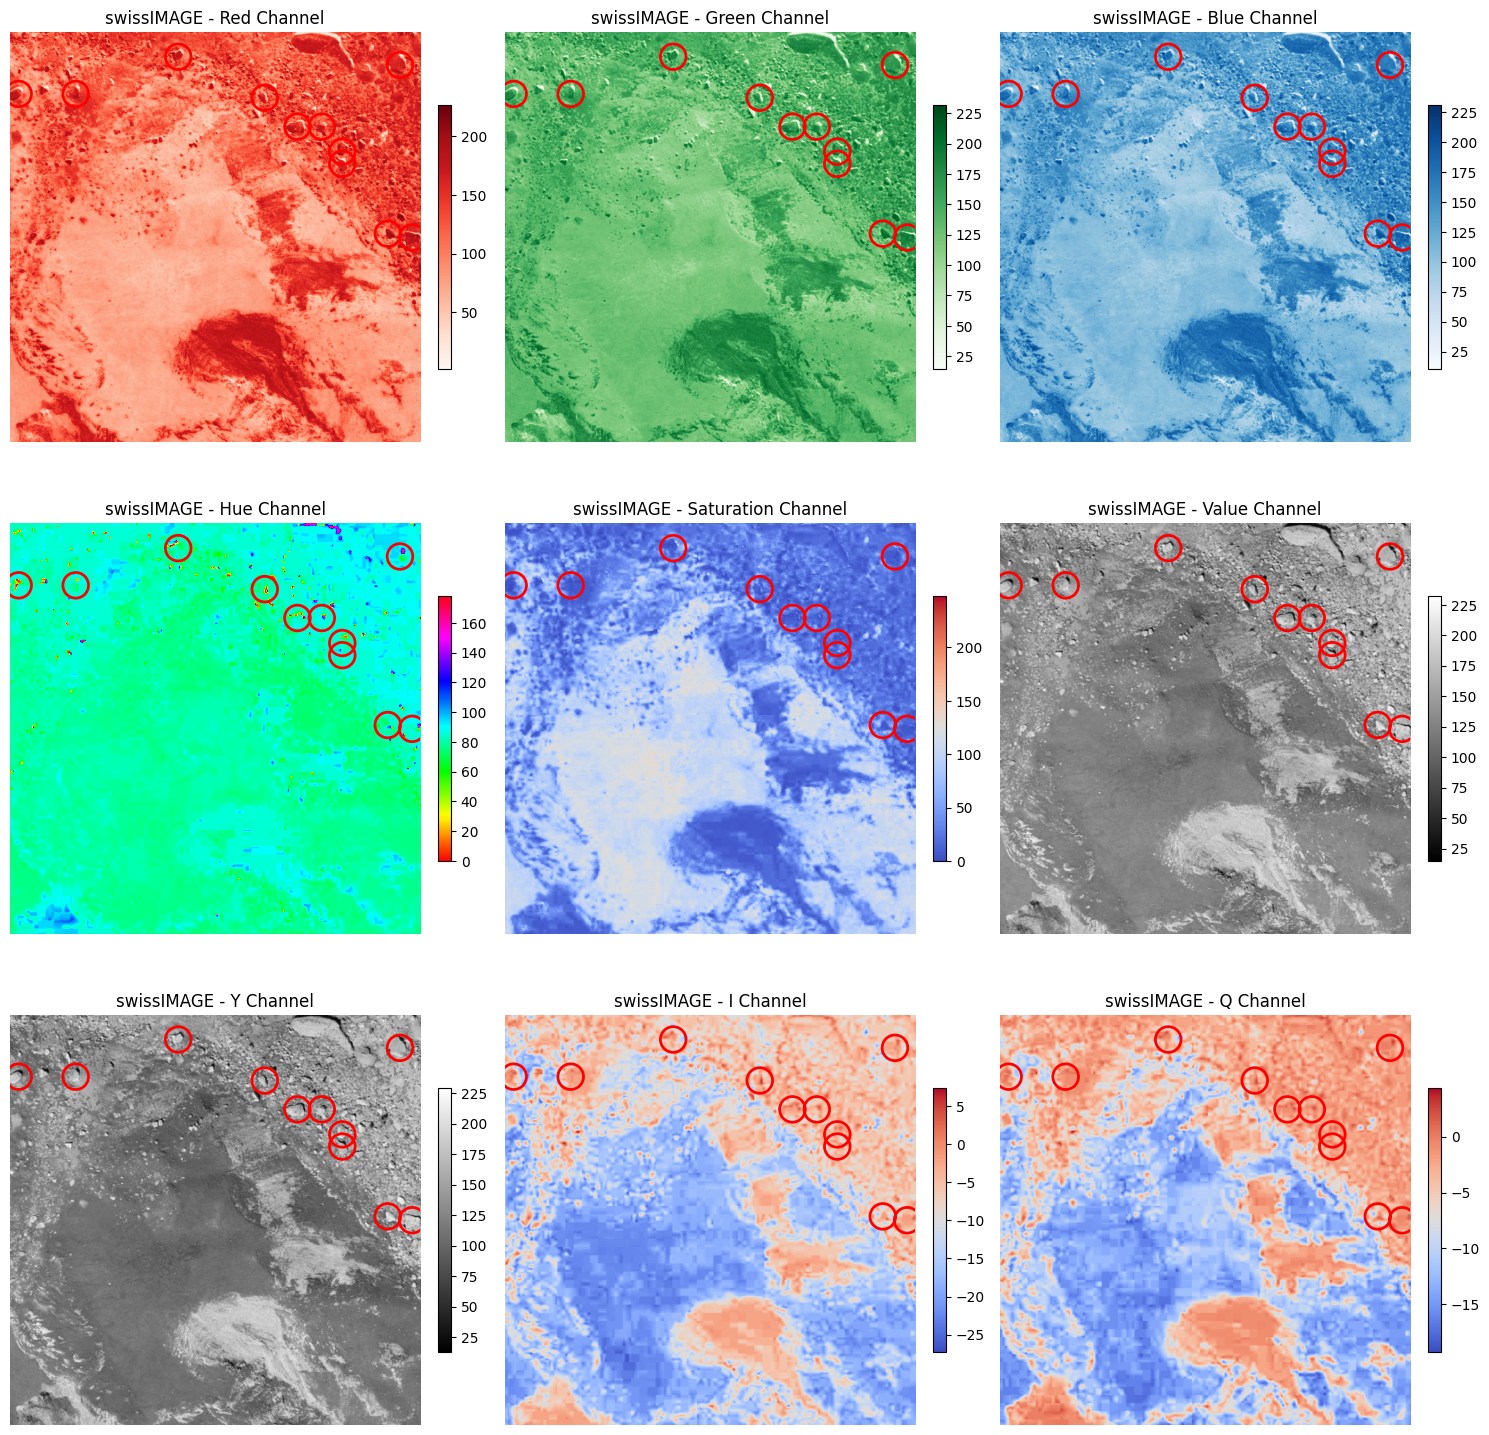

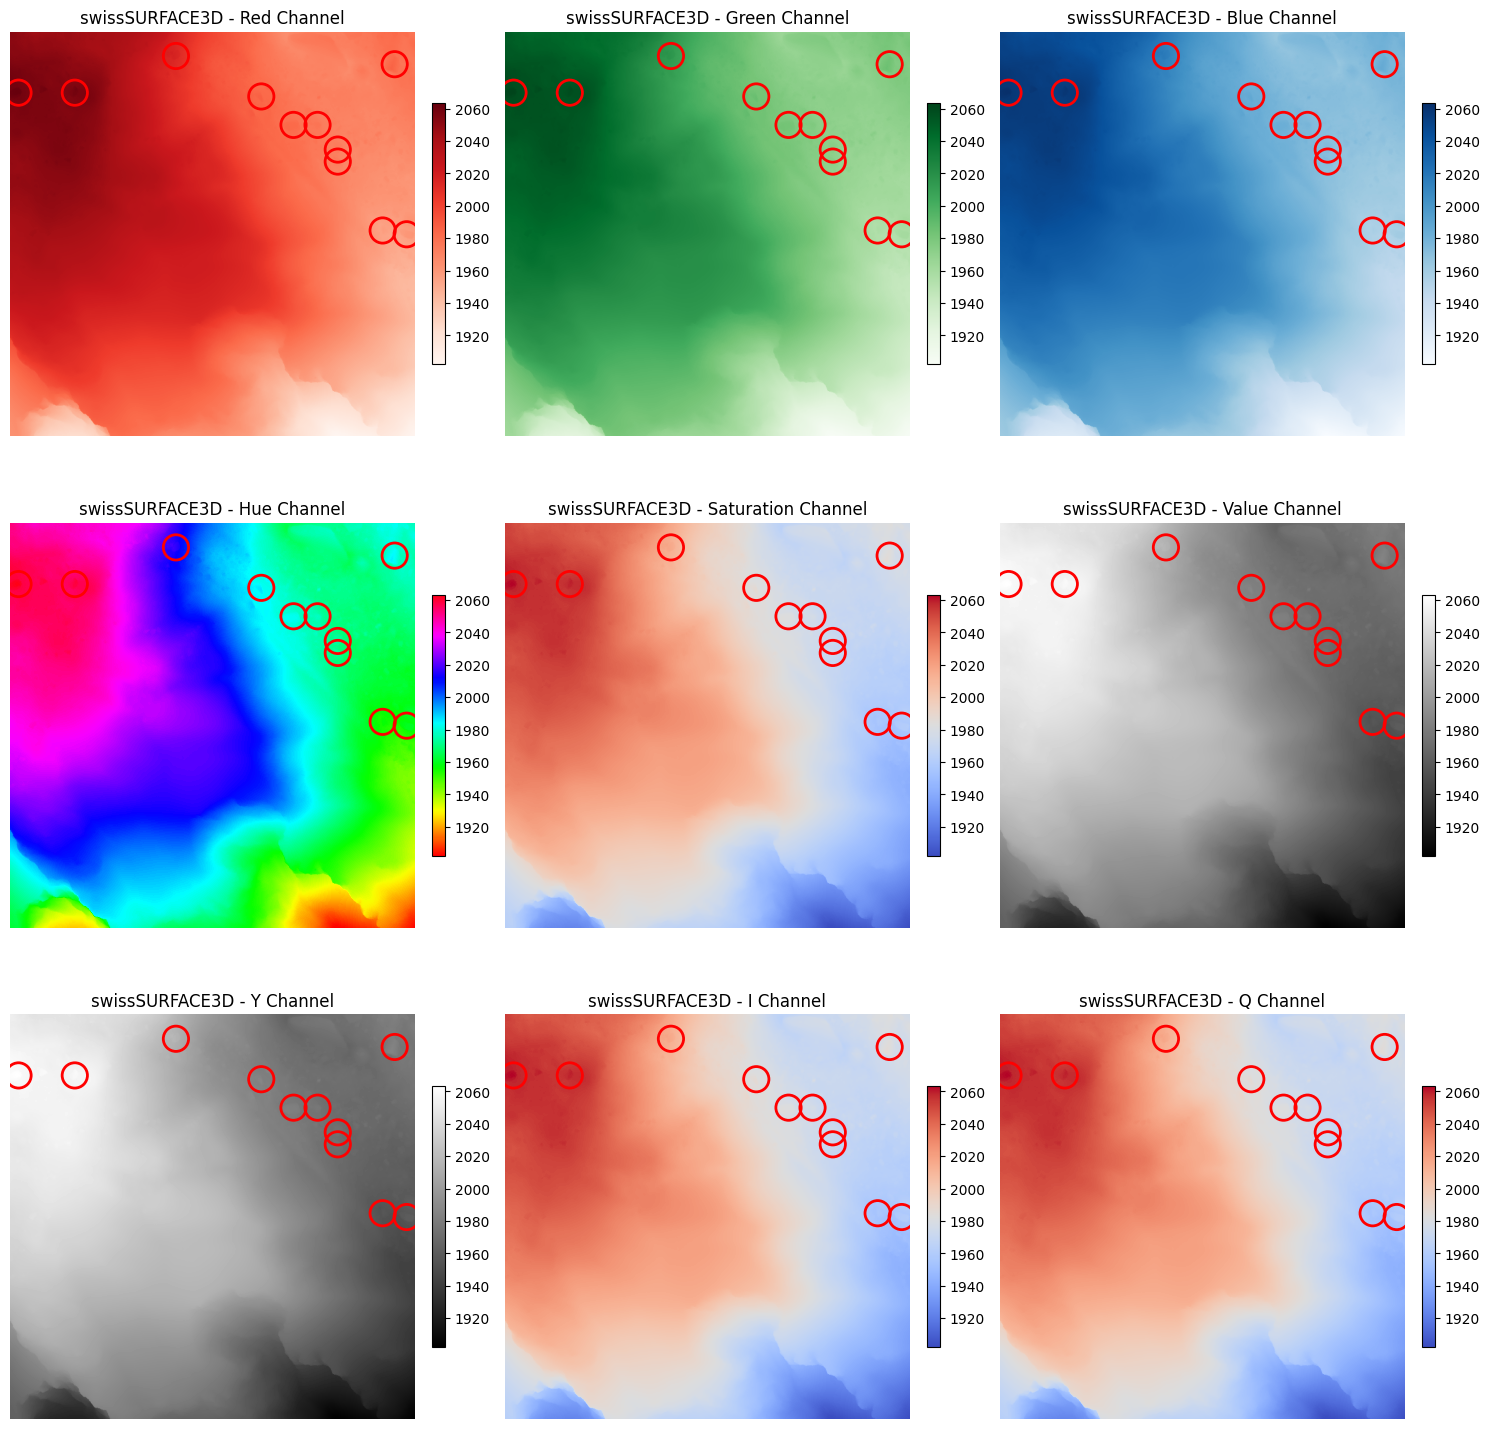

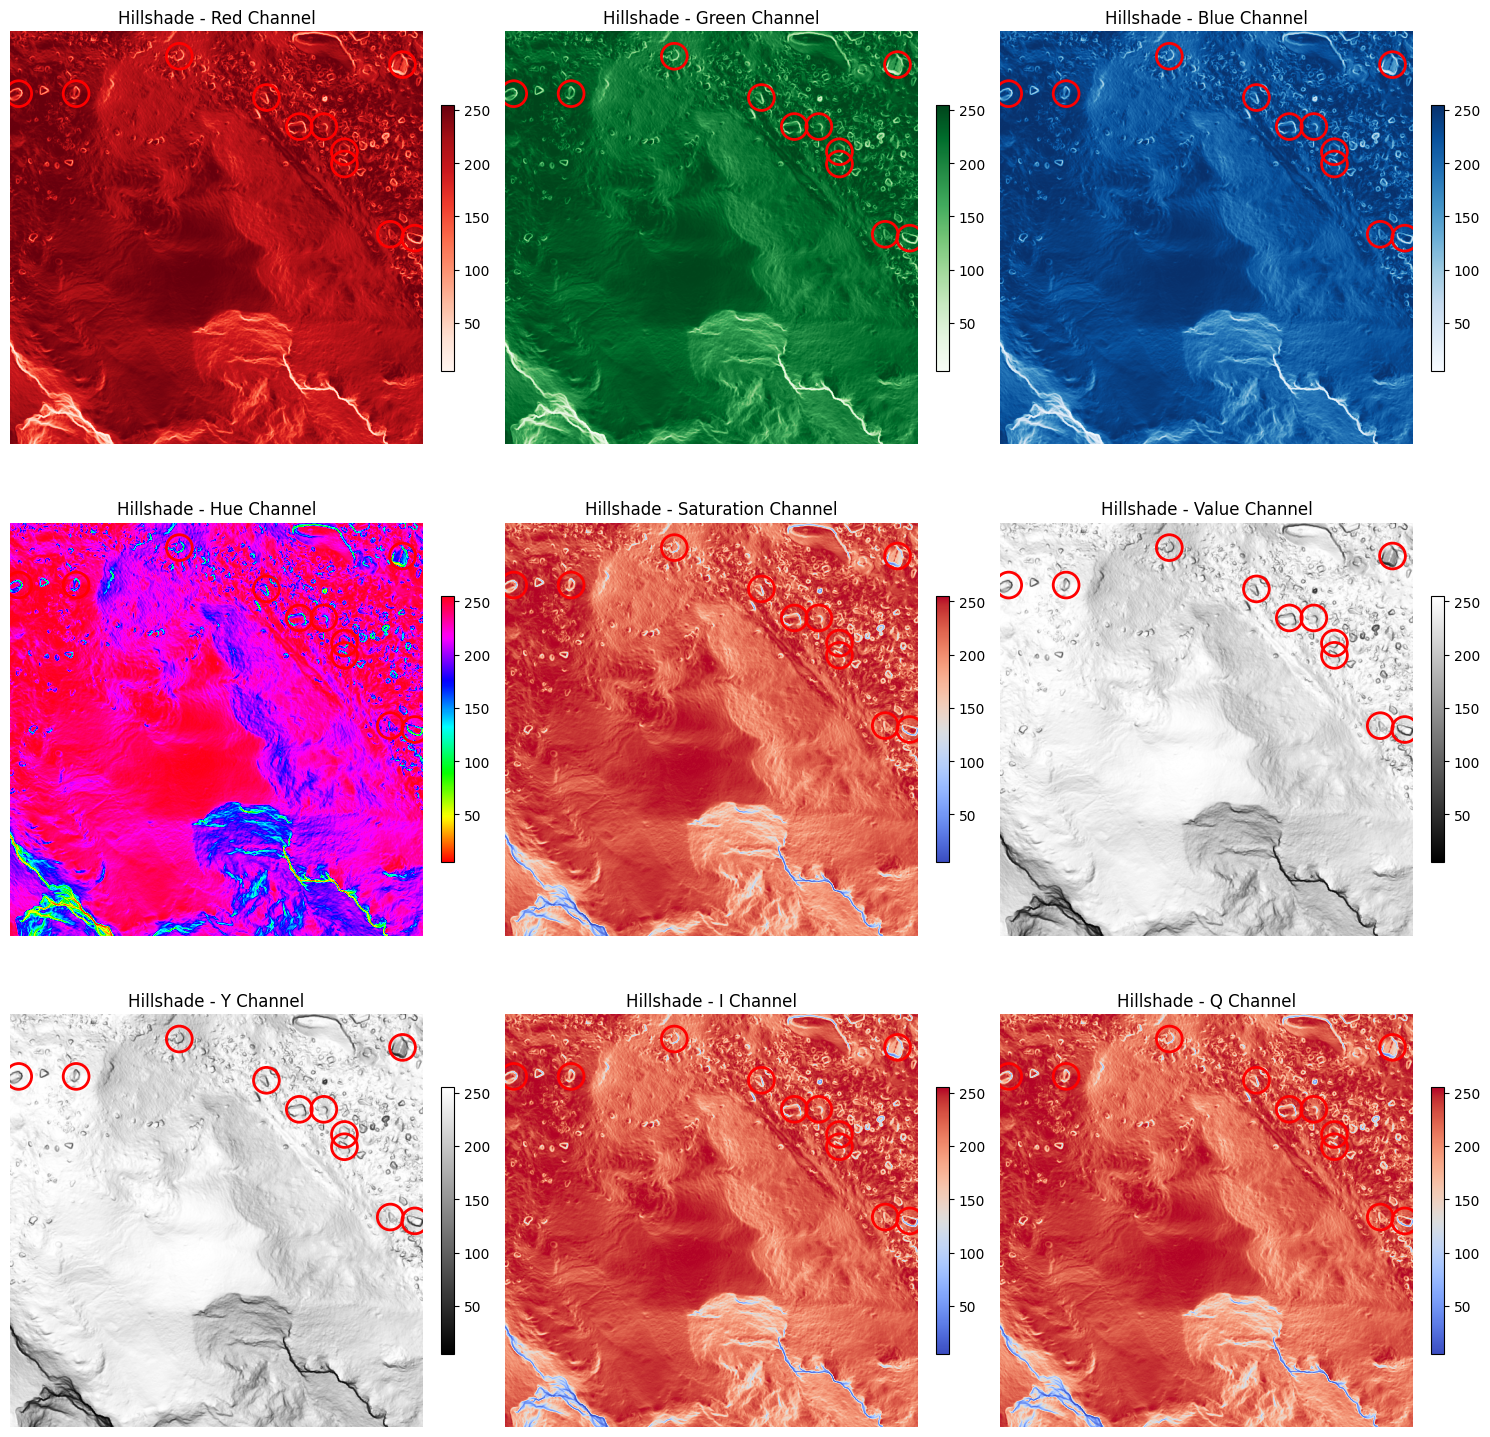

In [15]:
# Shuffle and plot for a random sample
random.shuffle(dataset)
plot_images_and_9_channels(sample_info)